In [1]:
# Install required libraries if necessary
!pip install numpy pandas tensorflow opencv-python matplotlib seaborn Pillow

In [5]:
import numpy as np
import pandas as pd
import os
import cv2
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess

# Set seaborn style and pandas options
sns.set_style("whitegrid")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

# Load the dataset paths
train_dir = '/content/drive/.shortcut-targets-by-id/1bEGa7cC2-xvrK9tK-CCvqmU7kohEPigp/malimg_dataset/train'
valid_dir = '/content/drive/.shortcut-targets-by-id/1bEGa7cC2-xvrK9tK-CCvqmU7kohEPigp/malimg_dataset/val'
test_dir = '/content/drive/.shortcut-targets-by-id/1bEGa7cC2-xvrK9tK-CCvqmU7kohEPigp/malimg_dataset/test'


In [7]:
folders = os.listdir(train_dir)

def read_data(folder):
    data, labels = [], []
    for label in tqdm(folders):
        path = f"{folder}/{label}/"
        folder_data = os.listdir(path)
        for image_path in folder_data:
            img = cv2.imread(path + image_path)
            img = cv2.resize(img, (224, 224))
            data.append(np.array(img))
            labels.append(label)

    return data, labels

train_data, train_labels = read_data(train_dir)
valid_data, valid_labels = read_data(valid_dir)
test_data, test_labels = read_data(test_dir)

train_data = np.array(train_data)
train_labels = np.array(train_labels)

valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Train Size: ", train_data.shape[0])
print("Validation Size: ", valid_data.shape[0])
print("Test Size: ", test_data.shape[0])


100%|██████████| 4/4 [00:28<00:00,  7.15s/it]

Train Size:  431
Validation Size:  52
Test Size:  59


In [8]:
from sklearn.preprocessing import LabelEncoder

# Encode the labels
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
valid_labels = le.transform(valid_labels)
test_labels = le.transform(test_labels)

# Convert labels to categorical
num_classes = len(le.classes_)
train_labels = to_categorical(train_labels, num_classes)
valid_labels = to_categorical(valid_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)


In [9]:
def build_model(base_model, preprocess_func):
    input_layer = tf.keras.Input((224, 224, 3))
    preprocessed_inputs = tf.keras.layers.Lambda(lambda x: preprocess_func(x))(input_layer)
    base_model = base_model(weights='imagenet', include_top=False, input_tensor=preprocessed_inputs)

    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Create the model architecture
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=input_layer, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

    return model


In [11]:
# Define the models to use
models = {
    "VGG16": build_model(VGG16, vgg16_preprocess),
    "ResNet50": build_model(ResNet50, resnet50_preprocess)
}

# Dictionary to hold training history
history = {}

# Train each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    history[model_name] = model.fit(train_data, train_labels, validation_data=(valid_data, valid_labels),
                                     epochs=10, batch_size=128, callbacks=[early_stopping], verbose=1)


Training VGG16...
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 13s/step - accuracy: 0.2364 - loss: 4.1532 - val_accuracy: 0.4615 - val_loss: 2.1831
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 478ms/step - accuracy: 0.5460 - loss: 1.7987 - val_accuracy: 0.5000 - val_loss: 1.1686
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step - accuracy: 0.5389 - loss: 1.0291 - val_accuracy: 0.7308 - val_loss: 0.7118
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 479ms/step - accuracy: 0.7416 - loss: 0.6332 - val_accuracy: 0.7692 - val_loss: 0.4161
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step - accuracy: 0.8307 - loss: 0.3213 - val_accuracy: 1.0000 - val_loss: 0.1636
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 491ms/step - accuracy: 0.9924 - loss: 0.1217 - val_accuracy: 1.0000 - val_loss: 0.1143
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 487ms/step - accuracy: 0.9957 - loss: 0.0787 - val_accuracy: 1.0000 - val_loss: 0.0928
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 486ms/step - accuracy: 1.0000 - loss: 0.0608 - val_accuracy: 1

In [12]:
def ensemble_predictions(models, data):
    predictions = [model.predict(data) for model in models.values()]
    # Average the predictions across all models
    avg_predictions = np.mean(predictions, axis=0)
    return avg_predictions


In [13]:
# Generate predictions using the ensemble method
ensemble_preds = ensemble_predictions(models, test_data)

# Convert predictions to class labels
ensemble_class_preds = np.argmax(ensemble_preds, axis=1)

# Convert test labels back to class indices
test_class_labels = np.argmax(test_labels, axis=1)

# Calculate accuracy
accuracy = np.mean(ensemble_class_preds == test_class_labels)
print(f'Ensemble Avarage Test Accuracy: {accuracy:.2f}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 24s 12s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step
Ensemble Test Accuracy: 1.00


In [15]:
def plot_training_history(history):
    # Create a figure with two subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # Plot Accuracy
    for model_name, hist in history.items():
        axes[0].plot(hist.history['accuracy'], label=f'{model_name} Train')
        axes[0].plot(hist.history['val_accuracy'], label=f'{model_name} Validation')

    axes[0].set_title('Model Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()

    # Plot Loss
    for model_name, hist in history.items():
        axes[1].plot(hist.history['loss'], label=f'{model_name} Train')
        axes[1].plot(hist.history['val_loss'], label=f'{model_name} Validation')

    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

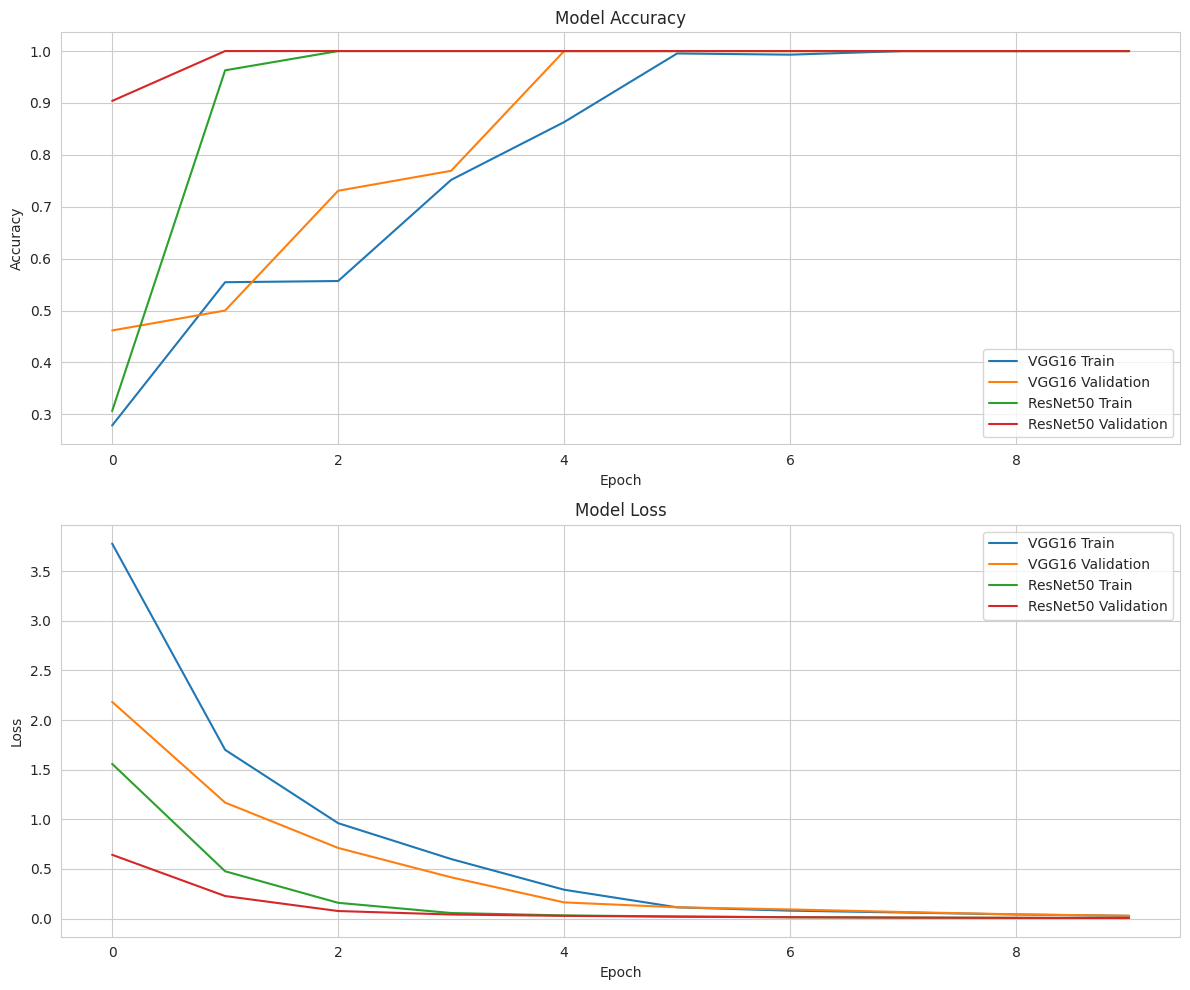

In [16]:
plot_training_history(history)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step 


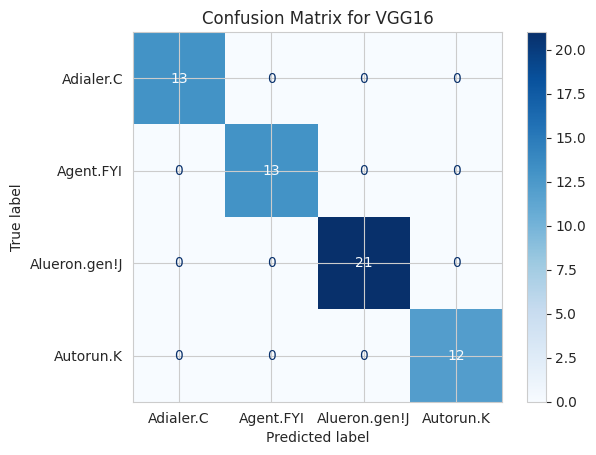

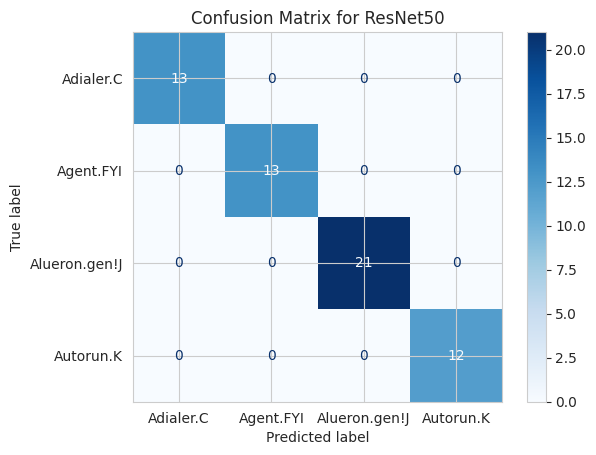

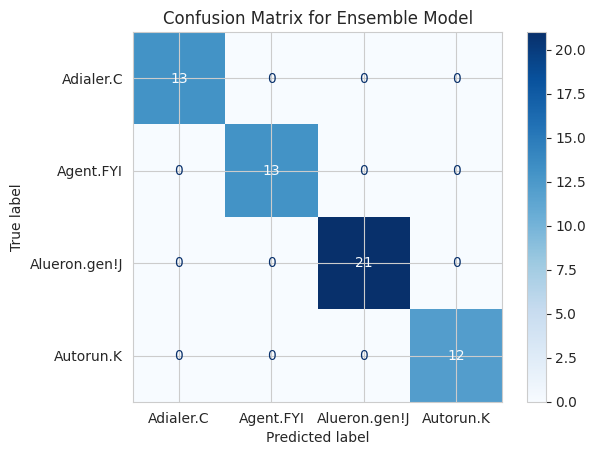

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Predictions for each model
vgg16_preds = models["VGG16"].predict(test_data)
vgg16_class_preds = np.argmax(vgg16_preds, axis=1)

resnet50_preds = models["ResNet50"].predict(test_data)
resnet50_class_preds = np.argmax(resnet50_preds, axis=1)

# Plot confusion matrices for each individual model
plot_confusion_matrix(test_class_labels, vgg16_class_preds, "VGG16")
plot_confusion_matrix(test_class_labels, resnet50_class_preds, "ResNet50")

# Plot confusion matrix for ensemble predictions
plot_confusion_matrix(test_class_labels, ensemble_class_preds, "Ensemble Model")
